### Import Dependencies

In [523]:
import pandas as pd
import numpy as np
import os
import matplotlib as plt

### Formulas

In [524]:
# The purpose of this formula is evaluate how often a particular team wins when they have the statistical advantage
# This percentage is used later to determine how much the algorithm can weigh the stats on a mathematically "better" team
# Outline for how it works:
# 1) User enters the WEEKLY dataframe they want to evaluate, and the TEAM they want the percentage for
# 2) A "base_df" is created from the weekly dataframe that only includes games played by the identified team
# 3) From the base_df, a list of the team's opponents is stored
# 4) The code loops through each opponent from the list in (3)
# 5) The TEAM is compared against each OPPONENT, and they are labelled the "winner" and "loser" based on the Results column
# 6) The numerical stats are compared in a simple > or < evaluation. Greater Offensive stats get a point, and lesser
#    defensive stats get a point.
# 7) Categorical stats, like QB and coaching staff, are compared based on the overall record of that person. That record
#    is evaluated from the allteam dataframe, regardless of team, opponent, year, or week. 
# 8) At the end of the loop, if the winning team has more of the statistical advantages, then that counter increases by one
# 9) After all opponents have been looped through, the formula calculates the % of times the winner had more advantages

def majperc(df, base, adv='none'):

    ##### Set evaluation formulas ######
    
    # Determines which categorical value has a higher win record and assigns a point to that team
    def cat_greater_point(column='', base='none'):
        win_value = win_row[column].sum()
        loss_value = loss_row[column].sum()

        if base == 'none':
            win_df = allteam_df[allteam_df[column] == win_value]
            loss_df = allteam_df[allteam_df[column] == loss_value]
        else:
            win_df = allteam_df[(allteam_df[column] == win_value) & (allteam_df['Base_Team'] == base)]
            loss_df = allteam_df[(allteam_df[column] == loss_value) & (allteam_df['Base_Team'] == base)]

        if len(win_df['Results']) == 0:
            if len(loss_df['Results']) == 0:
                base_count = 0
                base_sub = 0
            else:
                base_count = 0
                base_sub = 1
        elif len(loss_df['Results']) == 0:
            base_count = 1
            base_sub = 1
        else:
            win_rate = win_df['Results'].sum()/len(win_df['Results'])
            loss_rate = loss_df['Results'].sum()/len(loss_df['Results'])
            if win_rate > loss_rate:
                base_count = 1
            else:
                base_count = 0  
            base_sub = 1

        return base_count, base_sub
    
    # Determines which numerical value is greater and assigns a point to that team
    def num_greater_point(column='', weight=1):
        win_base = win_row[column].sum()
        loss_base = loss_row[column].sum()

        if win_base > loss_base:
            base_count = weight
        else:
            base_count = 0  
        base_sub = 1

        return base_count, base_sub
    
    #Determines which numerical value is lesser and assigns a point to that team
    def num_lesser_point(column='', weight=1):
        win_base = win_row[column].sum()
        loss_base = loss_row[column].sum()

        if win_base < loss_base:
            base_count = weight
        else:
            base_count = 0  
        base_sub = 1

        return base_count, base_sub
    
    #################################
    
    base_df = df[df['Base_Team'] == base]
    base_opps = base_df['Opp']
    base_total = 0
    base_maj = 0
    base_half = 0
    
    for opp in base_opps:

        teams = [base, opp]
        game_df = df.loc[(df['Base_Team'].isin(teams)) & (df['Opp'].isin(teams))]
        win_row = game_df.loc[(game_df['Results'] == 1)]
        loss_row = game_df.loc[(game_df['Results'] == 0)]

        winner = win_row['Base_Team'].sum()
        loser = loss_row['Base_Team'].sum()

        # Count Advantages
        
        HCbase_count, HCbase_sub = cat_greater_point(column='Head_Coach')
        OCbase_count, OCbase_sub = cat_greater_point(column='OC')
        DCbase_count, DCbase_sub = cat_greater_point(column='DC')
        QBbase_count, QBbase_sub = cat_greater_point(column='QB')
        
        DAYbase_count, DAYbase_sub = cat_greater_point(base=base, column='Day')
        HOMEbase_count, HOMEbase_sub = cat_greater_point(base=base, column='Home')
        ABbase_count, ABbase_sub = cat_greater_point(base=base, column='After_Bye')
                
        WTbase_count, WTbase_sub = num_greater_point(column='Wins Tally')
        
        if adv == 'off':
            offw = 3
            defw = 1
        elif adv == 'def':
            offw = 1
            defw = 3
        else:
            offw = 1
            defw = 1
        
        PFbase_count, PFbase_sub = num_greater_point(column='PF Tally', weight=offw)
        OTYbase_count, OTYbase_sub = num_greater_point(column='OTotYd Tally', weight=offw)
        OPYbase_count, OPYbase_sub = num_greater_point(column='OPassY Tally', weight=offw)
        ORYbase_count, ORYbase_sub = num_greater_point(column='ORushY Tally', weight=offw)
        TOWbase_count, TOWbase_sub = num_greater_point(column='TO_won Tally', weight=offw)
        
        PAbase_count, PAbase_sub = num_lesser_point(column='PA Tally', weight=defw)
        DTYbase_count, DTYbase_sub = num_lesser_point(column='DTotYd Tally', weight=defw)
        DPYbase_count, DPYbase_sub = num_lesser_point(column='DPassY Tally', weight=defw)
        DRYbase_count, DRYbase_sub = num_lesser_point(column='DRushY Tally', weight=defw)
        TOLbase_count, TOLbase_sub = num_lesser_point(column='TO_lost Tally', weight=defw)

        count_list = [HCbase_count, OCbase_count, DCbase_count, QBbase_count, DAYbase_count, HOMEbase_count, ABbase_count, 
                      WTbase_count, PFbase_count, OTYbase_count, OPYbase_count, ORYbase_count, TOWbase_count, PAbase_count, 
                      DTYbase_count, DPYbase_count, DRYbase_count, TOLbase_count]
        
        sub_list = [HCbase_sub, OCbase_sub, DCbase_sub, QBbase_sub, DAYbase_sub, HOMEbase_sub, ABbase_sub, WTbase_sub, 
                    PFbase_sub, OTYbase_sub, OPYbase_sub, ORYbase_sub, TOWbase_sub, PAbase_sub, DTYbase_sub, DPYbase_sub, 
                    DRYbase_sub, TOLbase_sub]
        
        count = sum(count_list)
        sub = sum(sub_list)
        
        # Summation Calcs
        if count > sub/2:
            base_maj = base_maj + 1
            base_total = base_total + 1
        else:
            base_total = base_total + 1

    base_majperc = (base_maj/base_total) * 100
        
    return base_majperc

In [525]:
# Compares how well each team performs in the specified week and predicts a winner based on those precentages

def weekly_win_rate(weekly_df, team, opponent):
    
    df = weekly_df
    
    base_df = df[df['Base_Team'] == team]
    opp_df = df[df['Base_Team'] == opponent]
    
    # Weekly win rate for each team
    base_week_rate = base_df['Results'].sum()/len(base_df['Results'])
    opp_week_rate = opp_df['Results'].sum()/len(opp_df['Results'])
    
    if base_week_rate > opp_week_rate:
        weekrate_winner = team
        weekrate_perc = (base_week_rate/(base_week_rate + opp_week_rate)) * 100
    else:
        weekrate_winner = opponent
        weekrate_perc = (opp_week_rate/(base_week_rate + opp_week_rate)) * 100
    
    return weekrate_winner, weekrate_perc

In [526]:
# Compares how these teams have performed against each other in the past and predicts a winner based on those results

def priors_win_rate(team, opponent):
    priors_df = allteam_df[(allteam_df['Base_Team'] == team) & (allteam_df['Opp'] == opponent)]
    if len(priors_df['Results']) == 0:
        priorrate_winner = 'None'
        priorrate_perc = 0
    else:
        base_priors_rate = priors_df['Results'].sum()/len(priors_df['Results'])
        opp_priors_rate = (len(priors_df['Results']) - priors_df['Results'].sum())/len(priors_df['Results'])
        if base_priors_rate > opp_priors_rate:
            priorrate_winner = team
            priorrate_perc = (base_priors_rate/(base_priors_rate + opp_priors_rate)) * 100
            
        elif base_priors_rate == opp_priors_rate:
            priorrate_winner = 'Even'
            priorrate_perc = 50
        else:
            priorrate_winner = opponent
            priorrate_perc = (opp_priors_rate/(base_priors_rate + opp_priors_rate)) * 100
            
    return priorrate_winner, priorrate_perc

In [527]:
# Advantage tally for each team in the upcoming matchup

def adv_win_rate(weekly_df, team, opponent, adv='none'):
    
    ######### Set Evaluation Formulas #########
    def base_opp_greater_point_cat(column='', team='none', opponent='none', weight=1):
        base_v = base_adv_row[column].sum()
        opp_v = opp_adv_row[column].sum()
        if team == 'none':
            base_v_df = allteam_df[allteam_df[column] == base_v]
            opp_v_df = allteam_df[allteam_df[column] == opp_v]
        else:
            base_v_df = allteam_df[(allteam_df[column] == base_v) & (allteam_df['Base_Team'] == team)]
            opp_v_df = allteam_df[(allteam_df[column] == opp_v) & (allteam_df['Base_Team'] == opponent)]

        if len(base_v_df['Results']) == 0:
            if len(opp_v_df['Results']) == 0:
                base_adv_count = 0
                opp_adv_count = 0
                adv_sub = 0
            else:
                base_adv_count = 0
                opp_adv_count = weight
                adv_sub = weight
        elif len(opp_v_df['Results']) == 0:
            base_adv_count = weight
            opp_adv_count = 0
            adv_sub = weight
        else:
            base_v_rate = base_v_df['Results'].sum()/len(base_v_df['Results'])
            opp_v_rate = opp_v_df['Results'].sum()/len(opp_v_df['Results'])
            if base_v_rate > opp_v_rate:
                base_adv_count = weight
                opp_adv_count = 0
                adv_sub = weight
            elif base_v_rate < opp_v_rate:
                base_adv_count = 0
                opp_adv_count = weight
                adv_sub = weight
            else:
                base_adv_count = 0
                opp_adv_count = 0
                adv_sub = 0
                
        return base_adv_count, opp_adv_count, adv_sub
    
    def base_opp_greater_point_num(column='', weight=1):
        
        tal_base = base_adv_row[column].sum()
        tal_opp = opp_adv_row[column].sum()
        
        if column == 'Wins Tally':
            weight = abs(tal_base - tal_opp)
            win_weight = 1
        else:
            win_weight = weight
        
        if tal_base > tal_opp:
            base_adv_count = weight
            opp_adv_count = 0
            adv_sub = win_weight
        elif tal_base < tal_opp:
            base_adv_count = 0
            opp_adv_count = weight
            adv_sub = win_weight
        else:
            base_adv_count = 0
            opp_adv_count = 0
            adv_sub = 0
            
        return base_adv_count, opp_adv_count, adv_sub
    
    def base_opp_lesser_point_num(column='', weight=1):
        tal_base = base_adv_row[column].sum()
        tal_opp = opp_adv_row[column].sum()
        
        if tal_base < tal_opp:
            base_adv_count = weight
            opp_adv_count = 0
            adv_sub = weight
        elif tal_base > tal_opp:
            base_adv_count = 0
            opp_adv_count = weight
            adv_sub = weight
        else:
            base_adv_count = 0
            opp_adv_count = 0
            adv_sub = 0
            
        return base_adv_count, opp_adv_count, adv_sub
    ##################################################
    
    df = weekly_df
    
    base_df = df[df['Base_Team'] == team]
    opp_df = df[df['Base_Team'] == opponent]
    
    teams = [team, opponent]
    adv_df = df.loc[(df['Base_Team'].isin(teams)) & (df['Opp'].isin(teams)) & (df['Year'] == 2020)]
    
    base_adv_row = adv_df.loc[df['Base_Team'] == team]
    opp_adv_row = adv_df.loc[df['Base_Team'] == opponent]
    
    ## Assign Advantages
    HCbase_adv_count, HCopp_adv_count, HCadv_sub = base_opp_greater_point_cat(column='Head_Coach')
    OCbase_adv_count, OCopp_adv_count, OCadv_sub = base_opp_greater_point_cat(column='OC')
    DCbase_adv_count, DCopp_adv_count, DCadv_sub = base_opp_greater_point_cat(column='DC')
    QBbase_adv_count, QBopp_adv_count, QBadv_sub = base_opp_greater_point_cat(column='QB')
    DAYbase_adv_count, DAYopp_adv_count, DAYadv_sub = base_opp_greater_point_cat(column='Day', team=team, opponent=opponent)
    HOMEbase_adv_count, HOMEopp_adv_count, HOMEadv_sub = base_opp_greater_point_cat(column='Home', team=team, opponent=opponent)
    ABbase_adv_count, ABopp_adv_count, ABadv_sub = base_opp_greater_point_cat(column='After_Bye', team=team, opponent=opponent)
    WTbase_adv_count, WTopp_adv_count, WTadv_sub = base_opp_greater_point_num(column='Wins Tally')
    
    if adv == 'off':
        PFbase_adv_count, PFopp_adv_count, PFadv_sub = base_opp_greater_point_num(column='PF Tally', weight=3)
        OTYbase_adv_count, OTYopp_adv_count, OTYadv_sub = base_opp_greater_point_num(column='OTotYd Tally', weight=3)
        OPYbase_adv_count, OPYopp_adv_count, OPYadv_sub = base_opp_greater_point_num(column='OPassY Tally', weight=3)
        ORYbase_adv_count, ORYopp_adv_count, ORYadv_sub = base_opp_greater_point_num(column='ORushY Tally', weight=3)
        TOWbase_adv_count, TOWopp_adv_count, TOWadv_sub = base_opp_greater_point_num(column='TO_won Tally', weight=3)
    else:
        PFbase_adv_count, PFopp_adv_count, PFadv_sub = base_opp_greater_point_num(column='PF Tally')
        OTYbase_adv_count, OTYopp_adv_count, OTYadv_sub = base_opp_greater_point_num(column='OTotYd Tally')
        OPYbase_adv_count, OPYopp_adv_count, OPYadv_sub = base_opp_greater_point_num(column='OPassY Tally')
        ORYbase_adv_count, ORYopp_adv_count, ORYadv_sub = base_opp_greater_point_num(column='ORushY Tally')
        TOWbase_adv_count, TOWopp_adv_count, TOWadv_sub = base_opp_greater_point_num(column='TO_won Tally')

    if adv == 'def':
        PAbase_adv_count, PAopp_adv_count, PAadv_sub = base_opp_lesser_point_num(column='PA Tally', weight=3)
        DTYbase_adv_count, DTYopp_adv_count, DTYadv_sub = base_opp_lesser_point_num(column='DTotYd Tally', weight=3)
        DPYbase_adv_count, DPYopp_adv_count, DPYadv_sub = base_opp_lesser_point_num(column='DPassY Tally', weight=3)
        DRYbase_adv_count, DRYopp_adv_count, DRYadv_sub = base_opp_lesser_point_num(column='DRushY Tally', weight=3)
        TOLbase_adv_count, TOLopp_adv_count, TOLadv_sub = base_opp_lesser_point_num(column='TO_lost Tally', weight=3)
    else:
        PAbase_adv_count, PAopp_adv_count, PAadv_sub = base_opp_lesser_point_num(column='PA Tally')
        DTYbase_adv_count, DTYopp_adv_count, DTYadv_sub = base_opp_lesser_point_num(column='DTotYd Tally')
        DPYbase_adv_count, DPYopp_adv_count, DPYadv_sub = base_opp_lesser_point_num(column='DPassY Tally')
        DRYbase_adv_count, DRYopp_adv_count, DRYadv_sub = base_opp_lesser_point_num(column='DRushY Tally')
        TOLbase_adv_count, TOLopp_adv_count, TOLadv_sub = base_opp_lesser_point_num(column='TO_lost Tally')

    ## Tally Advantage
    
    base_adv_count_list = [HCbase_adv_count, OCbase_adv_count, DCbase_adv_count, QBbase_adv_count, DAYbase_adv_count, 
                          HOMEbase_adv_count, ABbase_adv_count, WTbase_adv_count, PFbase_adv_count, OTYbase_adv_count, 
                          OPYbase_adv_count, ORYbase_adv_count, TOWbase_adv_count, PAbase_adv_count, DTYbase_adv_count, 
                          DPYbase_adv_count, DRYbase_adv_count, TOLbase_adv_count]
    
    opp_adv_count_list = [HCopp_adv_count, OCopp_adv_count, DCopp_adv_count, QBopp_adv_count, DAYopp_adv_count, 
                         HOMEopp_adv_count, ABopp_adv_count, WTopp_adv_count, PFopp_adv_count, OTYopp_adv_count, 
                         OPYopp_adv_count, ORYopp_adv_count, TOWopp_adv_count, PAopp_adv_count, DTYopp_adv_count, 
                         DPYopp_adv_count, DRYopp_adv_count, TOLopp_adv_count]

    adv_sub_list = [HCadv_sub, OCadv_sub, DCadv_sub, QBadv_sub, DAYadv_sub, 
                    HOMEadv_sub, ABadv_sub, WTadv_sub, PFadv_sub, 
                    OTYadv_sub, OPYadv_sub, ORYadv_sub, TOWadv_sub, 
                    PAadv_sub, DTYadv_sub, DPYadv_sub, DRYadv_sub, TOLadv_sub]
    
    base_adv_count = sum(base_adv_count_list)
    opp_adv_count = sum(opp_adv_count_list)
    adv_sub = sum(adv_sub_list)
    
    return base_adv_count, opp_adv_count, adv_sub

In [528]:
# This formula compiles the advantages and win percentages from prior formulas, and weighs the result of each team
# against each other. If one team tends to win when they have the advantage, while their opponent tends to win when 
# they have the disadvantage, then the percentages are weighed against each other to see which pattern is stronger.

def summary_advperc(weekly_df, team, opponent, adv='none'):
    
    base_adv_count, opp_adv_count, adv_sub = adv_win_rate(weekly_df=weekly_df, team=team, opponent=opponent, adv=adv)
    
    base_majperc = majperc(df=weekly_df, base=team, adv=adv)
    opp_majperc = majperc(df=weekly_df, base=opponent, adv=adv)
    
    # Summation Calcs
    if base_adv_count > opp_adv_count:
        
        if base_majperc >= 50:
            if opp_majperc >= 50:
                advrate_perc = (base_majperc + opp_majperc)/2
                advrate_winner = team
            else:
                advrate_perc = (base_majperc + opp_majperc)/2
                if advrate_perc >= 50:
                    advrate_winner = team
                else:
                    advrate_perc = 100 - advrate_perc
                    advrate_winner = opponent
        else:
            if opp_majperc <= 50:
                advrate_perc = 100 - ((base_majperc + opp_majperc)/2)
                advrate_winner = opponent
            else:
                advrate_perc = (base_majperc + opp_majperc)/2
                if advrate_perc >= 50:
                    advrate_winner = team
                else:
                    advrate_perc = 100 - advrate_perc
                    advrate_winner = opponent
                    
    elif base_adv_count == opp_adv_count:
        
        advrate_perc = 50
        advrate_winner = 'None'
    
    else:
        
        if opp_majperc >= 50:
            if base_majperc >= 50:
                advrate_perc = (opp_majperc + base_majperc)/2
                advrate_winner = opponent
            else:
                advrate_perc = (opp_majperc + base_majperc)/2
                if advrate_perc >= 50:
                    advrate_winner = opponent
                else:
                    advrate_perc = 100 - advrate_perc
                    advrate_winner = team
                    
        else:
            if base_majperc <= 50:
                advrate_perc = 100 - ((opp_majperc + base_majperc)/2)
                advrate_winner = team
            else:
                advrate_perc = (opp_majperc + base_majperc)/2
                if advrate_perc >= 50:
                    advrate_winner = opponent
                else:
                    advrate_perc = 100 - advrate_perc
                    advrate_winner = team
                    
    return advrate_winner, advrate_perc

In [529]:
# Prints the predictions from the various methods as text

def predictions_byteam(weekly_df, team='', opponent='', adv='none', trunc=False):
    
    base_majperc = majperc(df=weekly_df, base=team, adv=adv)
    opp_majperc = majperc(df=weekly_df, base=opponent, adv=adv)
    weekrate_winner, weekrate_perc = weekly_win_rate(weekly_df=weekly_df, team=team, opponent=opponent)
    priorrate_winner, priorrate_perc = priors_win_rate(team=team, opponent=opponent)
    base_adv_count, opp_adv_count, adv_sub = adv_win_rate(weekly_df=weekly_df, team=team, opponent=opponent, adv=adv)
    advrate_winner, advrate_perc = summary_advperc(weekly_df=weekly_df, team=team, opponent=opponent, adv=adv)
    
    if weekrate_winner == priorrate_winner:
        prediction = weekrate_winner
    elif weekrate_winner == advrate_winner:
        prediction = weekrate_winner
    elif priorrate_winner == advrate_winner:
        prediction = priorrate_winner
    else:
        prediction = 'None'
    
    print('---------------')
    print(f'{team} vs. {opponent} :: {prediction}')
    
    if trunc == True:
        pass
    else:
        print('--')
        print(f'Based on Week: {weekrate_perc:.1f}% {weekrate_winner}')

        if priorrate_winner == 'None':
            print(f'Based on Past: These teams have not met in the last 10 seasons.')
        elif priorrate_winner == 'Even':
            print(f'Based on Past: Even record.')
        else:
            print(f'Based on Past: {priorrate_perc:.1f}% {priorrate_winner}.')

        if advrate_winner == 'None':
            print(f'Based on Advs: {base_adv_count} vs. {opp_adv_count}, no advantage.')
        else:
            print(f'Based on Advs: {advrate_perc:.1f}% {advrate_winner}')

In [530]:
# Prints the predictions from the various methods as text

def predictions(weekly_df, year=2020, adv='none', trunc=False):
  
    week_df = weekly_df[weekly_df['Year'] == year]
    unique_games = week_df[week_df['Home'] == 1]
    winners_list = unique_games['Base_Team'].to_list()
    losers_list = unique_games['Opp'].to_list()
    
    for team in winners_list:
        for opponent in losers_list:
            teams = [team, opponent]
            game_df = weekly_df.loc[(weekly_df['Base_Team'].isin(teams)) & 
                                    (weekly_df['Opp'].isin(teams)) & 
                                    (weekly_df['Year'] == year)]
            
            if len(game_df) == 0:
                pass
            else:

                base_majperc = majperc(df=weekly_df, base=team, adv=adv)
                opp_majperc = majperc(df=weekly_df, base=opponent, adv=adv)
                weekrate_winner, weekrate_perc = weekly_win_rate(weekly_df=weekly_df, team=team, opponent=opponent)
                priorrate_winner, priorrate_perc = priors_win_rate(team=team, opponent=opponent)
                base_adv_count, opp_adv_count, adv_sub = adv_win_rate(weekly_df=weekly_df, team=team, opponent=opponent, adv=adv)
                advrate_winner, advrate_perc = summary_advperc(weekly_df=weekly_df, team=team, opponent=opponent, adv=adv)

                if weekrate_winner == priorrate_winner:
                    prediction = weekrate_winner
                elif weekrate_winner == advrate_winner:
                    prediction = weekrate_winner
                elif priorrate_winner == advrate_winner:
                    prediction = priorrate_winner
                else:
                    prediction = 'None'

                print('---------------')
                print(f'{team} vs. {opponent} :: {prediction}')
                
                if trunc == True:
                    pass
                else:
                    print('--')
                    print(f'Based on Week: {weekrate_perc:.1f}% chance the {weekrate_winner} win.')

                    if priorrate_winner == 'None':
                        print(f'Based on Past: These teams have not met in the last 10 seasons.')
                    elif priorrate_winner == 'Even':
                        print(f'Based on Past: These teams have an even record.')
                    else:
                        print(f'Based on Past: {priorrate_perc:.1f}% chance the {priorrate_winner} win.')

                    if advrate_winner == 'None':
                        print(f'Based on Advs: {base_adv_count} vs. {opp_adv_count}, no advantage.')
                    else:
                        print(f'Based on Advs: {advrate_perc:.1f}% chance the {advrate_winner} win.')

In [531]:
# Formula to measure the accuracy of each prediction method

def method_accuracy(weekly_df, year=2020, adv='none'):
    
    weekrate = 0
    priorrate = 0
    advrate = 0
    count_sub = 0

    two = 0
    two_count = 0
    three = 0
    three_count = 0
    
    week_df = weekly_df[weekly_df['Year'] == year]
    unique_games = week_df[week_df['Results'] == 1]
    winners_list = unique_games['Base_Team'].to_list()
    losers_list = unique_games['Opp'].to_list()
    
    for team in winners_list:
        for opponent in losers_list:
            teams = [team, opponent]
            game_df = weekly_df.loc[(weekly_df['Base_Team'].isin(teams)) & 
                                    (weekly_df['Opp'].isin(teams)) & 
                                    (weekly_df['Year'] == year)]
            
            if len(game_df) == 0:
                pass
            else:
                # print(f'{team} v. {opponent}')
                base_majperc = majperc(df=weekly_df, base=team, adv=adv)
                opp_majperc = majperc(df=weekly_df, base=opponent, adv=adv)
                weekrate_winner, weekrate_perc = weekly_win_rate(weekly_df=weekly_df, team=team, opponent=opponent)
                priorrate_winner, priorrate_perc = priors_win_rate(team=team, opponent=opponent)
                base_adv_count, opp_adv_count, adv_sub = adv_win_rate(weekly_df=weekly_df, team=team, opponent=opponent, adv=adv)
                advrate_winner, advrate_perc = summary_advperc(weekly_df=weekly_df, team=team, opponent=opponent, adv=adv)

                win_row = game_df.loc[(game_df['Results'] == 1)]
                winner = win_row['Base_Team'].sum()
                
                if weekrate_winner == winner:
                    weekrate = weekrate + 1
                    if priorrate_winner == winner:
                        priorrate = priorrate + 1
                        if advrate_winner == winner:
                            advrate = advrate + 1
                            three = three + 1
                            three_count = three_count + 1
                            count_sub = count_sub + 1
                        else:
                            two = two + 1
                            two_count = two_count + 1
                            count_sub = count_sub + 1
                    elif advrate_winner == winner:
                        advrate = advrate + 1
                        two = two + 1
                        two_count = two_count + 1
                        count_sub = count_sub + 1
                    else:
                        if priorrate_winner == advrate_winner:
                            two_count = two_count + 1
                            count_sub = count_sub + 1
                        else:
                            count_sub = count_sub + 1
                elif priorrate_winner == winner:
                    priorrate = priorrate + 1
                    if advrate_winner == winner:
                        advrate = advrate + 1
                        two = two + 1
                        two_count = two_count + 1
                        count_sub = count_sub + 1
                    else:
                        count_sub = count_sub + 1
                elif advrate_winner == winner:
                    advrate = advrate + 1
                    if priorrate_winner == weekrate_winner:
                        two_count = two_count + 1
                        count_sub = count_sub + 1
                    else:
                        count_sub = count_sub + 1
                else:
                    if weekrate_winner == advrate_winner:
                        if weekrate_winner == priorrate_winner:
                            three_count = three_count + 1
                            count_sub = count_sub + 1
                        else:
                            count_sub = count_sub + 1
                    else:
                        count_sub = count_sub + 1
    
    tot_weekrate = round((weekrate/count_sub)*100,2)
    tot_priorrate = round((priorrate/count_sub)*100,2)
    tot_advrate = round((advrate/count_sub)*100,2)

    if two_count == 0:
        two_acc = 0
    else:
        two_acc = round((two/two_count)*100,2)
        
    if three_count == 0:
        three_acc = 0
    else:
        three_acc = round((three/three_count)*100,2)
    
    #print(f'Week Rate Predictions: {tot_weekrate:.1f}% Accurate')
    #print(f'Prior Rate Predictions: {tot_priorrate:.1f}% Accurate')
    #print(f'Adv Rate Predictions: {tot_advrate:.1f}% Accurate')
    #print('-')
    #print(f'If All Metrics Agree: {three_acc:.1f}% Accuracy')
    #print(f'If Two Metrics Agree: {two_acc:.1f}% Accuracy')
    
    return tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count

In [532]:
def accuracy_df(year, adv='none'):
    
    column_names = ["Year", "Week", "Weekly_Rate_Accuracy", "Prior_Rate_Accuracy", "E_Adv_Rate_Accuracy", 
                    "3Agree_Accuracy", "3Agree_Count", "2Agree_Accuracy", "2Agree_Count"]

    plot_df = pd.DataFrame(columns = column_names)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy(week1, year=year, adv=adv)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy(week2, year=year, adv=adv)
    row = [year, 2, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy(week3, year=year, adv=adv)
    row = [year, 3, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy(week4, year=year, adv=adv)
    row = [year, 4, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy(week5, year=year, adv=adv)
    row = [year, 5, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy(week6, year=year, adv=adv)
    row = [year, 6, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy(week7, year=year, adv=adv)
    row = [year, 7, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy(week8, year=year, adv=adv)
    row = [year, 8, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy(week9, year=year, adv=adv)
    row = [year, 9, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy(week10, year=year, adv=adv)
    row = [year, 10, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy(week11, year=year, adv=adv)
    row = [year, 11, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy(week12, year=year, adv=adv)
    row = [year, 12, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy(week13, year=year, adv=adv)
    row = [year, 13, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy(week14, year=year, adv=adv)
    row = [year, 14, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy(week15, year=year, adv=adv)
    row = [year, 15, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy(week16, year=year, adv=adv)
    row = [year, 16, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy(week17, year=year, adv=adv)
    row = [year, 17, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    return plot_df

In [533]:
def accuracydf_sum(df):
    mean3 = df['3Agree_Accuracy'].mean()
    sum3 = df['3Agree_Count'].sum()

    mean2 = df['2Agree_Accuracy'].mean()
    sum2 = df['2Agree_Count'].sum()

    total_sum = sum3 + sum2

    mean = (((mean3*sum3)/100 + (mean2*sum2)/100)/total_sum)*100
    
    return mean, mean3, mean2

In [534]:
# Prints the predictions from the various methods as text

def wrong_teams(weekly_df, year=2020, adv='none'):
  
    week_df = weekly_df[weekly_df['Year'] == year]
    unique_games = week_df[week_df['Home'] == 1]
    winners_list = unique_games['Base_Team'].to_list()
    losers_list = unique_games['Opp'].to_list()
    
    overest_list = []
    underest_list = []
    
    for team in winners_list:
        for opponent in losers_list:
            teams = [team, opponent]
            game_df = weekly_df.loc[(weekly_df['Base_Team'].isin(teams)) & 
                                    (weekly_df['Opp'].isin(teams)) & 
                                    (weekly_df['Year'] == year)]
            
            if len(game_df) == 0:
                pass
            else:
                winner_df = game_df[game_df['Results'] == 1]
                winner = winner_df['Base_Team'].sum()
                loser = winner_df['Opp'].sum()
                
                base_majperc = majperc(df=weekly_df, base=team, adv=adv)
                opp_majperc = majperc(df=weekly_df, base=opponent, adv=adv)
                weekrate_winner, weekrate_perc = weekly_win_rate(weekly_df=weekly_df, team=team, opponent=opponent)
                priorrate_winner, priorrate_perc = priors_win_rate(team=team, opponent=opponent)
                base_adv_count, opp_adv_count, adv_sub = adv_win_rate(weekly_df=weekly_df, team=team, opponent=opponent, adv=adv)
                advrate_winner, advrate_perc = summary_advperc(weekly_df=weekly_df, team=team, opponent=opponent, adv=adv)

                if weekrate_winner == priorrate_winner:
                    prediction = weekrate_winner
                elif weekrate_winner == advrate_winner:
                    prediction = weekrate_winner
                elif priorrate_winner == advrate_winner:
                    prediction = priorrate_winner
                else:
                    prediction = 'None'

                if prediction == loser:
                    overest_list.append(prediction)
                    underest_list.append(winner)
                else:
                    pass
                    
    return overest_list, underest_list

In [535]:
def overunderest(year, adv='none'):
    overestimated_teams = []
    underestimated_teams = []

    if year == 2020:
        overest_list, underest_list = wrong_teams(weekly_df=week1, year=year, adv=adv)
        for team in overest_list:
            overestimated_teams.append(team)
        for team in underest_list:
            underestimated_teams.append(team)

        overest_list, underest_list = wrong_teams(weekly_df=week2, year=year, adv=adv)
        for team in overest_list:
            overestimated_teams.append(team)
        for team in underest_list:
            underestimated_teams.append(team)

        overest_list, underest_list = wrong_teams(weekly_df=week3, year=year, adv=adv)
        for team in overest_list:
            overestimated_teams.append(team)
        for team in underest_list:
            underestimated_teams.append(team)

        overest_list, underest_list = wrong_teams(weekly_df=week4, year=year, adv=adv)
        for team in overest_list:
            overestimated_teams.append(team)
        for team in underest_list:
            underestimated_teams.append(team)

        overest_list, underest_list = wrong_teams(weekly_df=week5, year=year, adv=adv)
        for team in overest_list:
            overestimated_teams.append(team)
        for team in underest_list:
            underestimated_teams.append(team)
            
    else:
        overest_list, underest_list = wrong_teams(weekly_df=week1, year=year, adv=adv)
        for team in overest_list:
            overestimated_teams.append(team)
        for team in underest_list:
            underestimated_teams.append(team)

        overest_list, underest_list = wrong_teams(weekly_df=week2, year=year, adv=adv)
        for team in overest_list:
            overestimated_teams.append(team)
        for team in underest_list:
            underestimated_teams.append(team)

        overest_list, underest_list = wrong_teams(weekly_df=week3, year=year, adv=adv)
        for team in overest_list:
            overestimated_teams.append(team)
        for team in underest_list:
            underestimated_teams.append(team)

        overest_list, underest_list = wrong_teams(weekly_df=week4, year=year, adv=adv)
        for team in overest_list:
            overestimated_teams.append(team)
        for team in underest_list:
            underestimated_teams.append(team)

        overest_list, underest_list = wrong_teams(weekly_df=week5, year=year, adv=adv)
        for team in overest_list:
            overestimated_teams.append(team)
        for team in underest_list:
            underestimated_teams.append(team)

        overest_list, underest_list = wrong_teams(weekly_df=week6, year=year, adv=adv)
        for team in overest_list:
            overestimated_teams.append(team)
        for team in underest_list:
            underestimated_teams.append(team)

        overest_list, underest_list = wrong_teams(weekly_df=week7, year=year, adv=adv)
        for team in overest_list:
            overestimated_teams.append(team)
        for team in underest_list:
            underestimated_teams.append(team)

        overest_list, underest_list = wrong_teams(weekly_df=week8, year=year, adv=adv)
        for team in overest_list:
            overestimated_teams.append(team)
        for team in underest_list:
            underestimated_teams.append(team)

        overest_list, underest_list = wrong_teams(weekly_df=week9, year=year, adv=adv)
        for team in overest_list:
            overestimated_teams.append(team)
        for team in underest_list:
            underestimated_teams.append(team)

        overest_list, underest_list = wrong_teams(weekly_df=week10, year=year, adv=adv)
        for team in overest_list:
            overestimated_teams.append(team)
        for team in underest_list:
            underestimated_teams.append(team)

        overest_list, underest_list = wrong_teams(weekly_df=week11, year=year, adv=adv)
        for team in overest_list:
            overestimated_teams.append(team)
        for team in underest_list:
            underestimated_teams.append(team)

        overest_list, underest_list = wrong_teams(weekly_df=week12, year=year, adv=adv)
        for team in overest_list:
            overestimated_teams.append(team)
        for team in underest_list:
            underestimated_teams.append(team)

        overest_list, underest_list = wrong_teams(weekly_df=week13, year=year, adv=adv)
        for team in overest_list:
            overestimated_teams.append(team)
        for team in underest_list:
            underestimated_teams.append(team)

        overest_list, underest_list = wrong_teams(weekly_df=week14, year=year, adv=adv)
        for team in overest_list:
            overestimated_teams.append(team)
        for team in underest_list:
            underestimated_teams.append(team)

        overest_list, underest_list = wrong_teams(weekly_df=week15, year=year, adv=adv)
        for team in overest_list:
            overestimated_teams.append(team)
        for team in underest_list:
            underestimated_teams.append(team)

        overest_list, underest_list = wrong_teams(weekly_df=week16, year=year, adv=adv)
        for team in overest_list:
            overestimated_teams.append(team)
        for team in underest_list:
            underestimated_teams.append(team)

        overest_list, underest_list = wrong_teams(weekly_df=week17, year=year, adv=adv)
        for team in overest_list:
            overestimated_teams.append(team)
        for team in underest_list:
            underestimated_teams.append(team)
        
    column_names = ["Team"]
    overest_df = pd.DataFrame(columns = column_names)
    overest_df['Team'] = overestimated_teams

    column_names = ["Team", "Count"]
    oest_df = pd.DataFrame(columns = column_names)
    oest_df['Team'] = overest_df['Team'].unique()

    oest_count = []
    for team in oest_df['Team']:
        o_count = overest_df['Team'].value_counts()[team]
        oest_count.append(o_count)
    oest_df['Count'] = oest_count

    oest_df = oest_df.sort_values(by='Team', ascending=False)

    column_names = ["Team"]
    underest_df = pd.DataFrame(columns = column_names)
    underest_df['Team'] = underestimated_teams

    column_names = ["Team", "Count"]
    uest_df = pd.DataFrame(columns = column_names)
    uest_df['Team'] = underest_df['Team'].unique()

    uest_count = []
    for team in uest_df['Team']:
        u_count = underest_df['Team'].value_counts()[team]
        uest_count.append(u_count)
    uest_df['Count'] = uest_count

    uest_df = uest_df.sort_values(by='Team', ascending=False)
        
    return oest_df, uest_df

In [536]:
def total_accuracy_df(adv='none'):

    seasons_list = [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]
    column_names = ["Season", "Total_Accuracy", "3Agree_Accuracy", "2Agree_Accuracy"]
    
    mean_list = []
    mean3_list = []
    mean2_list = []
    
    acc_df = pd.DataFrame(columns = column_names)
    
    for season in seasons_list:

        acc_year_df = accuracy_df(year=season, adv=adv)
        mean, mean3, mean2 = accuracydf_sum(acc_year_df)
        mean_list.append(mean)
        mean3_list.append(mean3)
        mean2_list.append(mean2)


    acc_df['Season'] = seasons_list
    acc_df['Total_Accuracy'] = mean_list
    acc_df['3Agree_Accuracy'] = mean3_list
    acc_df['2Agree_Accuracy'] = mean2_list
    
    return acc_df

### Import Weekly Data and Run Prediction & Accuracy Formulas

In [537]:
allteam_df = pd.read_csv('Resources/allteam_csvs/allteam_df_updated.csv')

In [538]:
week1 = pd.read_csv('Resources/weekly_csvs/week1.csv')
week2 = pd.read_csv('Resources/weekly_csvs/week2.csv')
week3 = pd.read_csv('Resources/weekly_csvs/week3.csv')
week4 = pd.read_csv('Resources/weekly_csvs/week4.csv')
week5 = pd.read_csv('Resources/weekly_csvs/week5.csv')
week6 = pd.read_csv('Resources/weekly_csvs/week6.csv')
week7 = pd.read_csv('Resources/weekly_csvs/week7.csv')
week8 = pd.read_csv('Resources/weekly_csvs/week8.csv')
week9 = pd.read_csv('Resources/weekly_csvs/week9.csv')
week10 = pd.read_csv('Resources/weekly_csvs/week10.csv')
week11 = pd.read_csv('Resources/weekly_csvs/week11.csv')
week12 = pd.read_csv('Resources/weekly_csvs/week12.csv')
week13 = pd.read_csv('Resources/weekly_csvs/week13.csv')
week14 = pd.read_csv('Resources/weekly_csvs/week14.csv')
week15 = pd.read_csv('Resources/weekly_csvs/week15.csv')
week16 = pd.read_csv('Resources/weekly_csvs/week16.csv')
week17 = pd.read_csv('Resources/weekly_csvs/week17.csv')

## Calculate the model's overall accuracy for each season

#### No Advantage Weight

In [344]:
even_totacc_df = total_accuracy_df(adv='none')

In [347]:
print(even_totacc_df['Total_Accuracy'].mean())
even_totacc_df

,Season,Total_Accuracy,3Agree_Accuracy,2Agree_Accuracy
0,2019,82.898137,89.371765,78.274118
1,2018,79.933971,81.242353,78.999412
2,2017,78.571828,76.876471,79.509412
3,2016,78.506098,84.201765,75.277059
4,2015,70.729968,69.733529,71.430588
5,2014,76.308581,82.966471,72.106471
6,2013,77.878134,76.928235,78.311176
7,2012,77.453404,68.395882,83.851176
8,2011,77.046346,73.429412,79.617059
9,2010,74.618882,70.055882,76.915294


In [350]:
even_totacc_df.to_csv('Resources/accuracy_data/even_adv/total_model_accuracy_2.csv')

#### Offensive Advantage Weight

In [351]:
off_totacc_df = total_accuracy_df(adv='off')

In [354]:
print(off_totacc_df['Total_Accuracy'].mean())
off_totacc_df

,Season,Total_Accuracy,3Agree_Accuracy,2Agree_Accuracy
0,2019,82.919644,89.371765,78.274118
1,2018,79.775527,81.242353,78.719412
2,2017,78.571828,76.876471,79.509412
3,2016,78.506098,84.201765,75.277059
4,2015,70.554606,69.733529,71.136471
5,2014,76.515309,81.985882,72.988824
6,2013,77.878134,76.928235,78.311176
7,2012,77.453404,68.395882,83.851176
8,2011,77.046346,73.429412,79.617059
9,2010,74.451102,70.055882,76.750588


In [356]:
off_totacc_df.to_csv('Resources/accuracy_data/off_adv/total_model_accuracy_2.csv')

#### Defensive Advantage Weight

In [359]:
def_totacc_df = total_accuracy_df(adv='def')

,Season,Total_Accuracy,3Agree_Accuracy,2Agree_Accuracy
0,2019,82.555000,89.371765,77.685882
1,2018,79.933971,81.242353,78.999412
2,2017,78.571828,76.876471,79.509412
3,2016,78.506098,84.201765,75.277059
4,2015,70.729968,69.733529,71.430588
5,2014,76.308581,82.966471,72.106471
6,2013,77.878134,76.928235,78.311176
7,2012,77.674919,68.395882,83.981765
8,2011,77.046346,73.429412,79.617059
9,2010,74.339491,70.055882,76.495294


In [360]:
print(def_totacc_df['Total_Accuracy'].mean())
def_totacc_df

Total
77.35443354945996
82.555
70.72996762007556
3Agree
77.32017647058822
89.37176470588236
68.39588235294117
2Agree
77.3414117647059
83.98176470588236
68.39588235294117


In [361]:
def_totacc_df.to_csv('Resources/accuracy_data/def_adv/total_model_accuracy_2.csv')

# Visualization

## Season Accuracy Ratings

In [539]:
import matplotlib.pyplot as plt

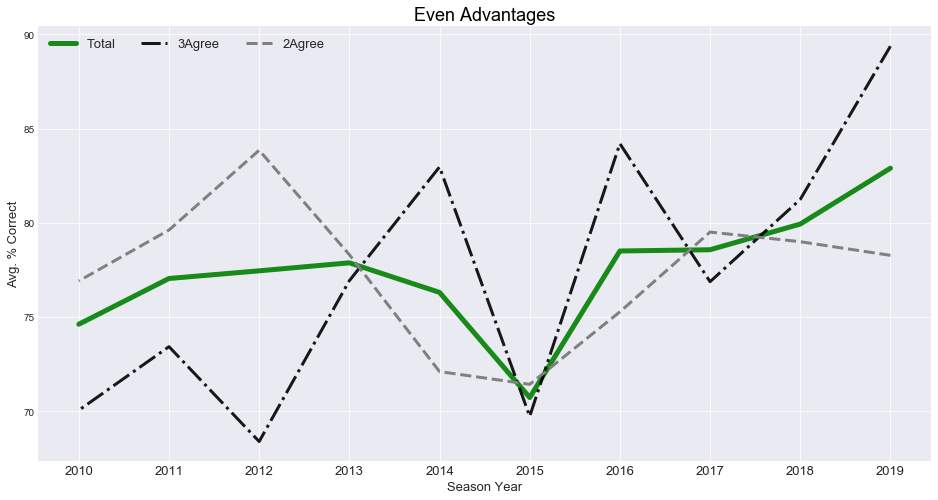

In [363]:
# style
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(16,8))
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
plt.plot(even_totacc_df['Season'], even_totacc_df['Total_Accuracy'], marker='', color='green', linewidth=5, alpha=0.9, label='Even Total')
plt.plot(even_totacc_df['Season'], even_totacc_df['3Agree_Accuracy'], linestyle='dashdot', marker='', color='black', linewidth=3, alpha=0.9, label='Even 3Agree')
plt.plot(even_totacc_df['Season'], even_totacc_df['2Agree_Accuracy'], linestyle='dashed', marker='', color='gray', linewidth=3, alpha=1, label='Even 2Agree')

# Add legend
plt.legend(loc=2, ncol=3, fontsize=13)
plt.xticks(even_totacc_df['Season'], fontsize=13)
plt.yticks(fontsize=13)
 
# Add titles
plt.title("Even Advantages", loc='center', fontsize=18, fontweight=0, color='black')
plt.xlabel("Season Year", fontsize=13)
plt.ylabel("Avg. % Correct", fontsize=13)

# Save
plt.savefig('Resources/accuracy_data/figures/even_adv_linechart.png')

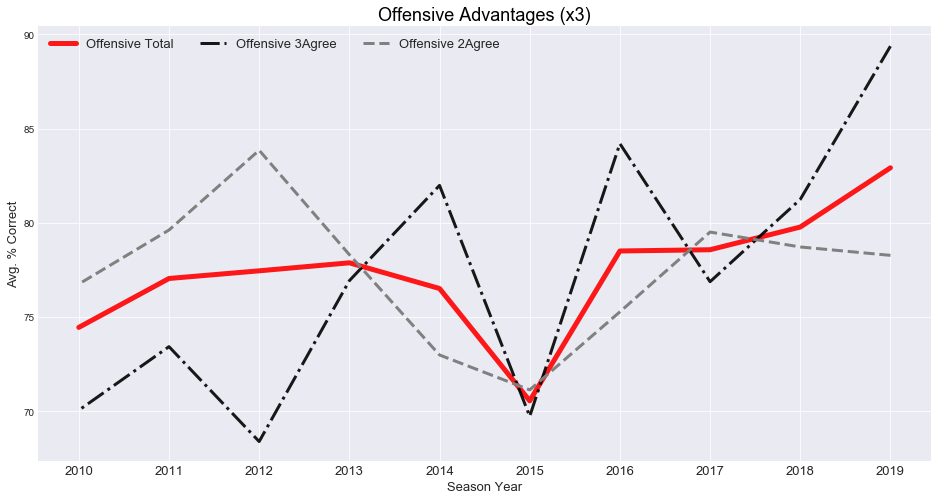

In [364]:
# style
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(16,8))
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
plt.plot(off_totacc_df['Season'], off_totacc_df['Total_Accuracy'], marker='', color='red', linewidth=5, alpha=0.9, label='Offensive Total')
plt.plot(off_totacc_df['Season'], off_totacc_df['3Agree_Accuracy'], linestyle='dashdot', marker='', color='black', linewidth=3, alpha=0.9, label='Offensive 3Agree')
plt.plot(off_totacc_df['Season'], off_totacc_df['2Agree_Accuracy'], linestyle='dashed', marker='', color='gray', linewidth=3, alpha=1, label='Offensive 2Agree')

# Add legend
plt.legend(loc=2, ncol=3, fontsize=13)
plt.xticks(off_totacc_df['Season'], fontsize=13)
plt.yticks(fontsize=13)
 
# Add titles
plt.title("Offensive Advantages (x3)", loc='center', fontsize=18, fontweight=0, color='black')
plt.xlabel("Season Year", fontsize=13)
plt.ylabel("Avg. % Correct", fontsize=13)

# Save
plt.savefig('Resources/accuracy_data/figures/off_adv_linechart.png')

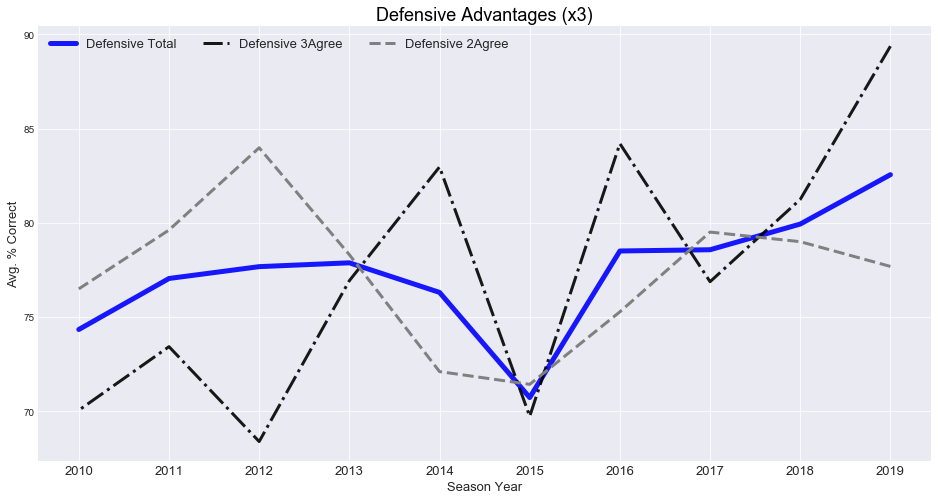

In [365]:
# style
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(16,8))
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
plt.plot(def_totacc_df['Season'], def_totacc_df['Total_Accuracy'], marker='', color='blue', linewidth=5, alpha=0.9, label='Defensive Total')
plt.plot(def_totacc_df['Season'], def_totacc_df['3Agree_Accuracy'], linestyle='dashdot', marker='', color='black', linewidth=3, alpha=0.9, label='Defensive 3Agree')
plt.plot(def_totacc_df['Season'], def_totacc_df['2Agree_Accuracy'], linestyle='dashed', marker='', color='gray', linewidth=3, alpha=1, label='Defensive 2Agree')

# Add legend
plt.legend(loc=2, ncol=3, fontsize=13)
plt.xticks(def_totacc_df['Season'], fontsize=13)
plt.yticks(fontsize=13)
 
# Add titles
plt.title("Defensive Advantages (x3)", loc='center', fontsize=18, fontweight=0, color='black')
plt.xlabel("Season Year", fontsize=13)
plt.ylabel("Avg. % Correct", fontsize=13)

# Save
plt.savefig('Resources/accuracy_data/figures/def_adv_linechart.png')

## Over/Underestimated Teams

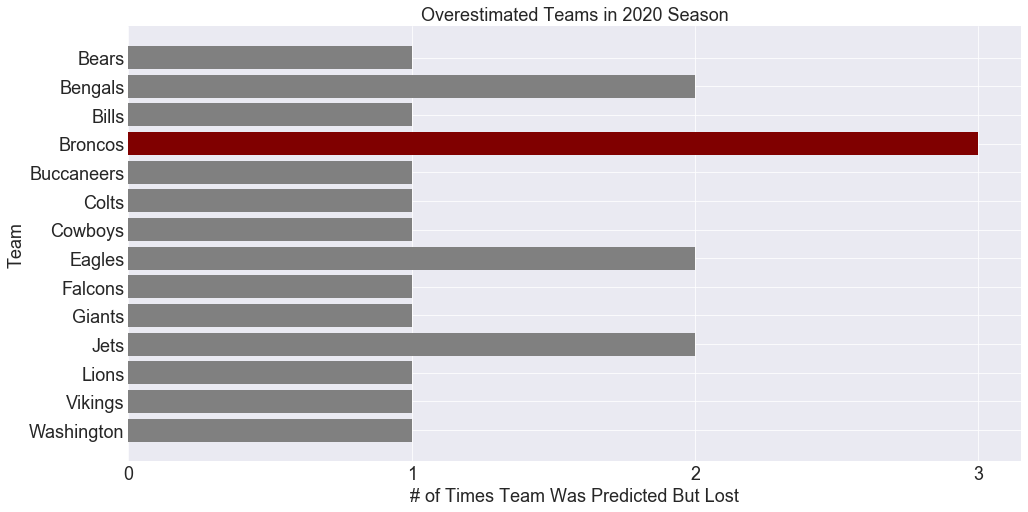

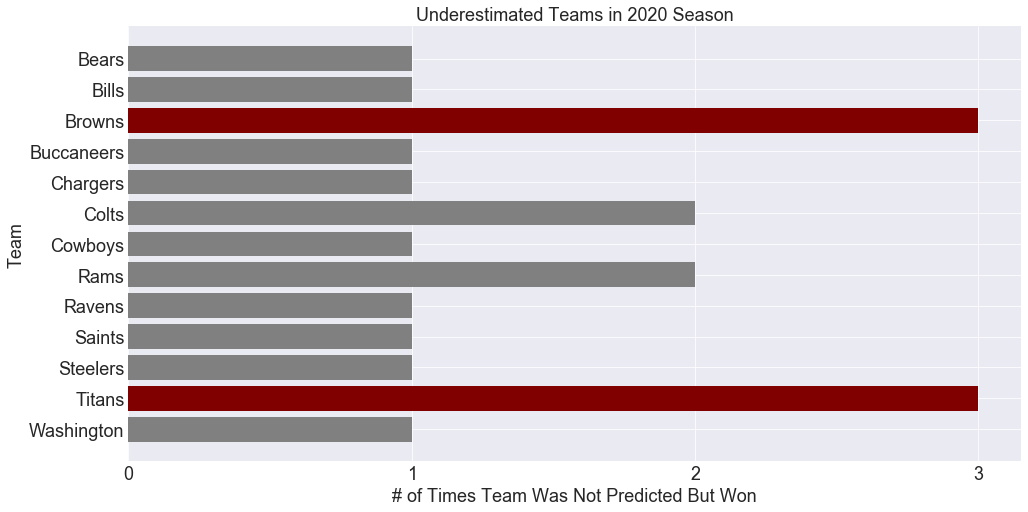

In [540]:
year = 2020

oest_df, uest_df = overunderest(year=year)

team = oest_df['Team'] 
count = oest_df['Count']
color = []

for number in count:
    if number == count.max():
        color.append('maroon')
    else:
        color.append('gray')
    
plt.figure(figsize=(16,8))
plt.barh(team, count, color=color)

# we also need to switch the labels
plt.xlabel('# of Times Team Was Predicted But Lost', fontsize=18)
plt.ylabel('Team', fontsize=18)
plt.title(f'Overestimated Teams in {year} Season', fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(np.arange(0, count.max()+1, 1), fontsize=18)

# Save
plt.savefig(f'Resources/accuracy_data/figures/overest{year}_barhchart.png')

team = uest_df['Team'] 
count = uest_df['Count']
color = []

for number in count:
    if number == count.max():
        color.append('maroon')
    else:
        color.append('gray')

plt.figure(figsize=(16,8))
plt.barh(team, count, color=color)

# we also need to switch the labels
plt.xlabel('# of Times Team Was Not Predicted But Won', fontsize=18)
plt.ylabel('Team', fontsize=18)
plt.title(f'Underestimated Teams in {year} Season', fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(np.arange(0, count.max()+1, 1), fontsize=18)

# Save
plt.savefig(f'Resources/accuracy_data/figures/underest{year}_barhchart.png')

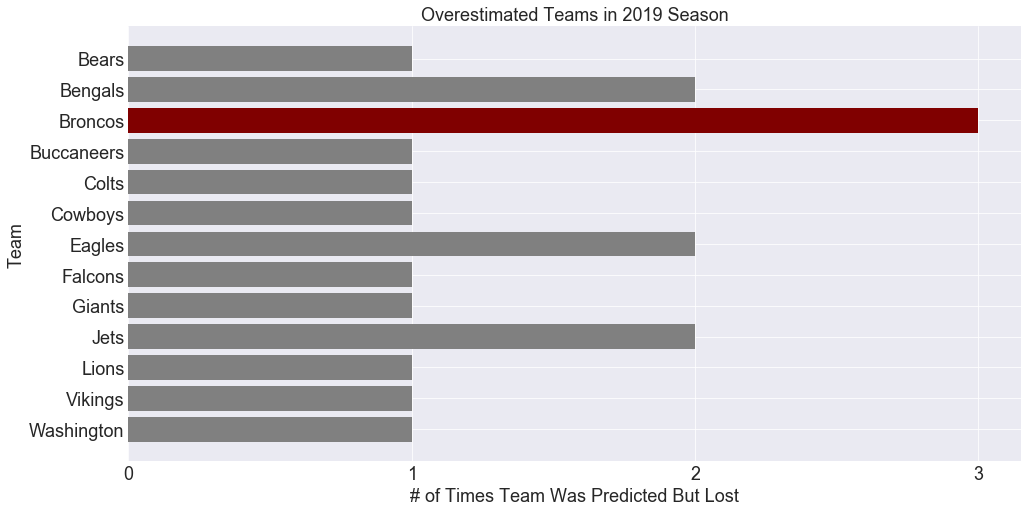

In [375]:
year = 2019

oest_df, uest_df = overunderest(year=year)

team = oest_df['Team'] 
count = oest_df['Count']
color = []

for number in count:
    if number == count.max():
        color.append('maroon')
    else:
        color.append('gray')
    
plt.figure(figsize=(16,8))
plt.barh(team, count, color=color)

# we also need to switch the labels
plt.xlabel('# of Times Team Was Predicted But Lost', fontsize=18)
plt.ylabel('Team', fontsize=18)
plt.title(f'Overestimated Teams in {year} Season', fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(np.arange(0, count.max()+1, 1), fontsize=18)

# Save
plt.savefig(f'Resources/accuracy_data/figures/overest{year}_barhchart.png')

team = uest_df['Team'] 
count = uest_df['Count']
color = []

for number in count:
    if number == count.max():
        color.append('maroon')
    else:
        color.append('gray')

plt.figure(figsize=(16,8))
plt.barh(team, count, color=color)

# we also need to switch the labels
plt.xlabel('# of Times Team Was Not Predicted But Won', fontsize=18)
plt.ylabel('Team', fontsize=18)
plt.title(f'Underestimated Teams in {year} Season', fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(np.arange(0, count.max()+1, 1), fontsize=18)

# Save
plt.savefig(f'Resources/accuracy_data/figures/underest{year}_barhchart.png')

In [377]:
year = 2018

oest_df, uest_df = overunderest(year=year)

team = oest_df['Team'] 
count = oest_df['Count']
color = []

for number in count:
    if number == count.max():
        color.append('maroon')
    else:
        color.append('gray')
    
plt.figure(figsize=(16,8))
plt.barh(team, count, color=color)

# we also need to switch the labels
plt.xlabel('# of Times Team Was Predicted But Lost', fontsize=18)
plt.ylabel('Team', fontsize=18)
plt.title(f'Overestimated Teams in {year} Season', fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(np.arange(0, count.max()+1, 1), fontsize=18)

# Save
plt.savefig(f'Resources/accuracy_data/figures/overest{year}_barhchart.png')

team = uest_df['Team'] 
count = uest_df['Count']
color = []

for number in count:
    if number == count.max():
        color.append('maroon')
    else:
        color.append('gray')

plt.figure(figsize=(16,8))
plt.barh(team, count, color=color)

# we also need to switch the labels
plt.xlabel('# of Times Team Was Not Predicted But Won', fontsize=18)
plt.ylabel('Team', fontsize=18)
plt.title(f'Underestimated Teams in {year} Season', fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(np.arange(0, count.max()+1, 1), fontsize=18)

# Save
plt.savefig(f'Resources/accuracy_data/figures/underest{year}_barhchart.png')

In [380]:
year = 2017

oest_df, uest_df = overunderest(year=year)

team = oest_df['Team'] 
count = oest_df['Count']
color = []

for number in count:
    if number == count.max():
        color.append('maroon')
    else:
        color.append('gray')
    
plt.figure(figsize=(16,8))
plt.barh(team, count, color=color)

# we also need to switch the labels
plt.xlabel('# of Times Team Was Predicted But Lost', fontsize=18)
plt.ylabel('Team', fontsize=18)
plt.title(f'Overestimated Teams in {year} Season', fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(np.arange(0, count.max()+1, 1), fontsize=18)

# Save
plt.savefig(f'Resources/accuracy_data/figures/overest{year}_barhchart.png')

team = uest_df['Team'] 
count = uest_df['Count']
color = []

for number in count:
    if number == count.max():
        color.append('maroon')
    else:
        color.append('gray')

plt.figure(figsize=(16,8))
plt.barh(team, count, color=color)

# we also need to switch the labels
plt.xlabel('# of Times Team Was Not Predicted But Won', fontsize=18)
plt.ylabel('Team', fontsize=18)
plt.title(f'Underestimated Teams in {year} Season', fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(np.arange(0, count.max()+1, 1), fontsize=18)

# Save
plt.savefig(f'Resources/accuracy_data/figures/underest{year}_barhchart.png')

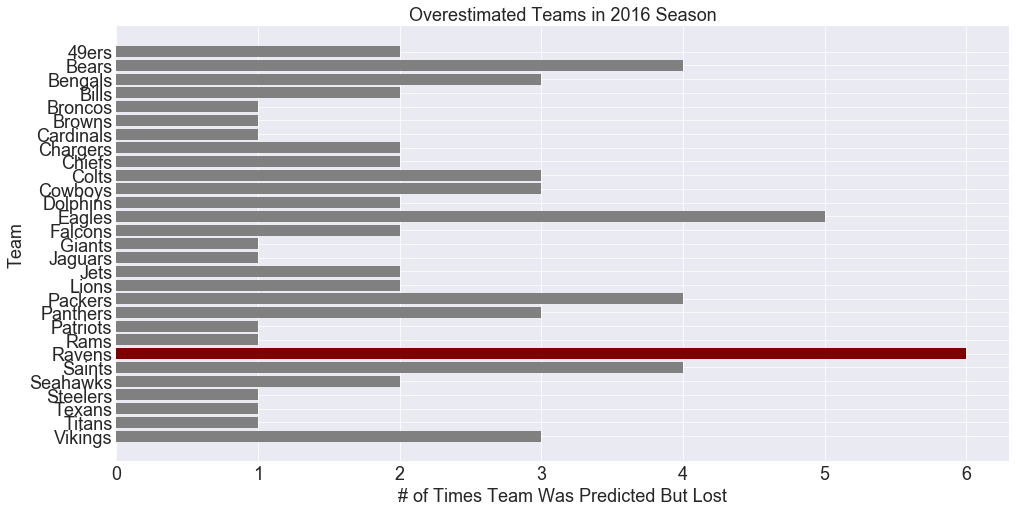

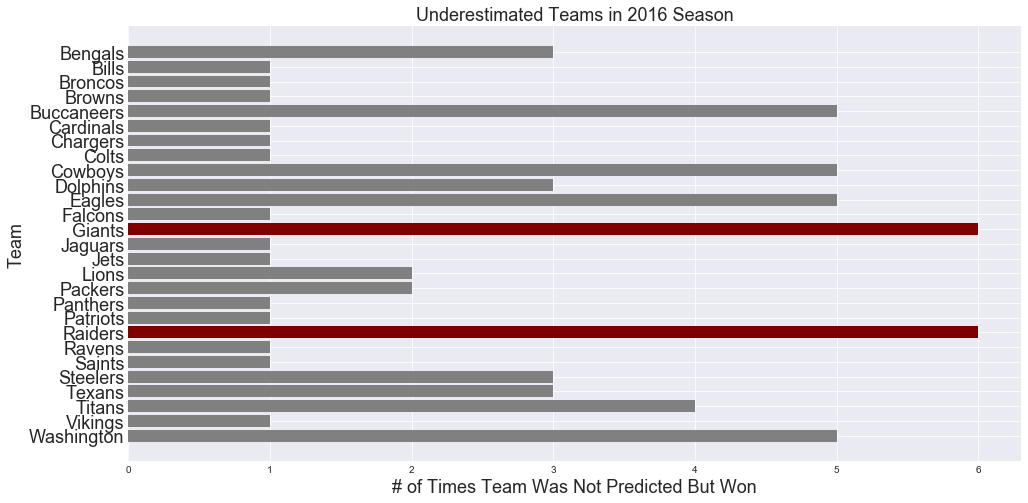

In [383]:
year = 2016

oest_df, uest_df = overunderest(year=year)

team = oest_df['Team'] 
count = oest_df['Count']
color = []

for number in count:
    if number == count.max():
        color.append('maroon')
    else:
        color.append('gray')
    
plt.figure(figsize=(16,8))
plt.barh(team, count, color=color)

# we also need to switch the labels
plt.xlabel('# of Times Team Was Predicted But Lost', fontsize=18)
plt.ylabel('Team', fontsize=18)
plt.title(f'Overestimated Teams in {year} Season', fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(np.arange(0, count.max()+1, 1), fontsize=18)

# Save
plt.savefig(f'Resources/accuracy_data/figures/overest{year}_barhchart.png')

team = uest_df['Team'] 
count = uest_df['Count']
color = []

for number in count:
    if number == count.max():
        color.append('maroon')
    else:
        color.append('gray')

plt.figure(figsize=(16,8))
plt.barh(team, count, color=color)

# we also need to switch the labels
plt.xlabel('# of Times Team Was Not Predicted But Won', fontsize=18)
plt.ylabel('Team', fontsize=18)
plt.title(f'Underestimated Teams in {year} Season', fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(np.arange(0, count.max()+1, 1), fontsize=18)

# Save
plt.savefig(f'Resources/accuracy_data/figures/underest{year}_barhchart.png')

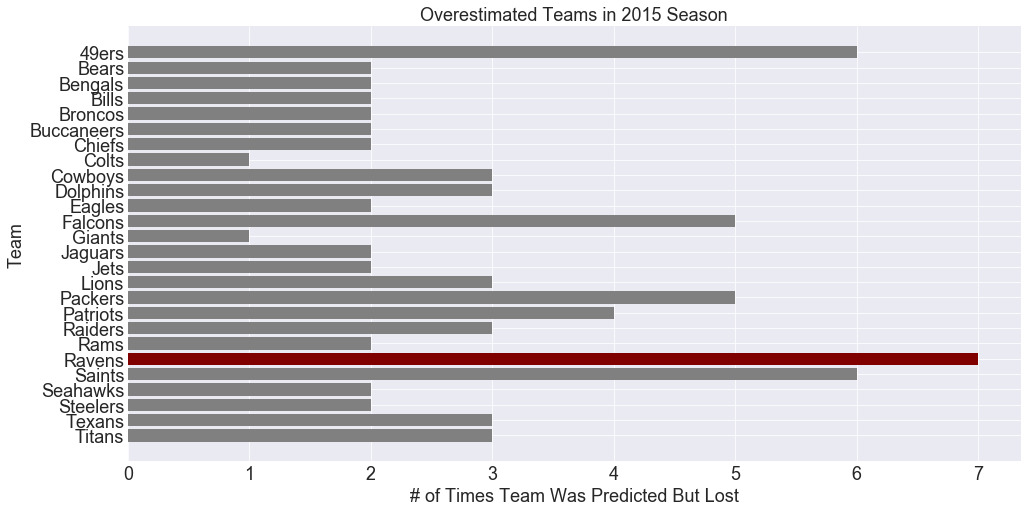

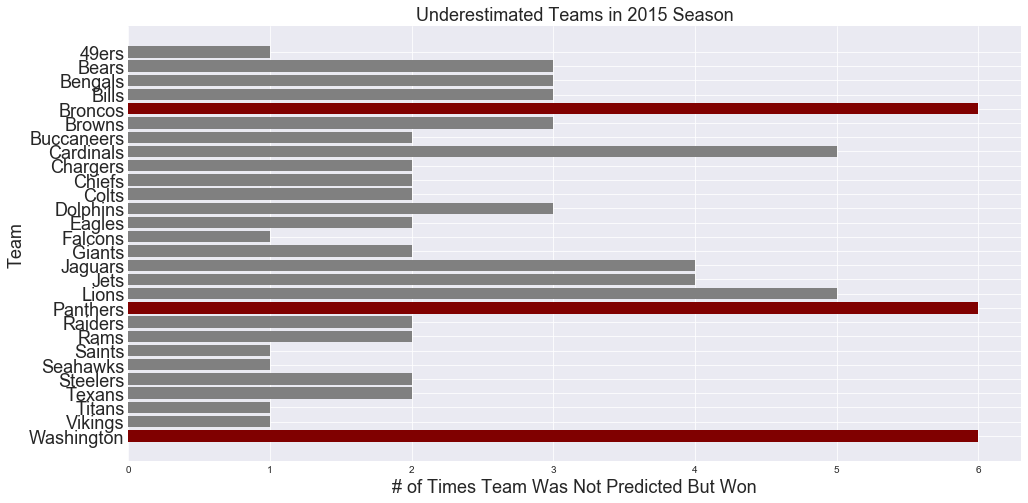

In [384]:
year = 2015

oest_df, uest_df = overunderest(year=year)

team = oest_df['Team'] 
count = oest_df['Count']
color = []

for number in count:
    if number == count.max():
        color.append('maroon')
    else:
        color.append('gray')
    
plt.figure(figsize=(16,8))
plt.barh(team, count, color=color)

# we also need to switch the labels
plt.xlabel('# of Times Team Was Predicted But Lost', fontsize=18)
plt.ylabel('Team', fontsize=18)
plt.title(f'Overestimated Teams in {year} Season', fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(np.arange(0, count.max()+1, 1), fontsize=18)

# Save
plt.savefig(f'Resources/accuracy_data/figures/overest{year}_barhchart.png')

team = uest_df['Team'] 
count = uest_df['Count']
color = []

for number in count:
    if number == count.max():
        color.append('maroon')
    else:
        color.append('gray')

plt.figure(figsize=(16,8))
plt.barh(team, count, color=color)

# we also need to switch the labels
plt.xlabel('# of Times Team Was Not Predicted But Won', fontsize=18)
plt.ylabel('Team', fontsize=18)
plt.title(f'Underestimated Teams in {year} Season', fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(np.arange(0, count.max()+1, 1), fontsize=18)

# Save
plt.savefig(f'Resources/accuracy_data/figures/underest{year}_barhchart.png')

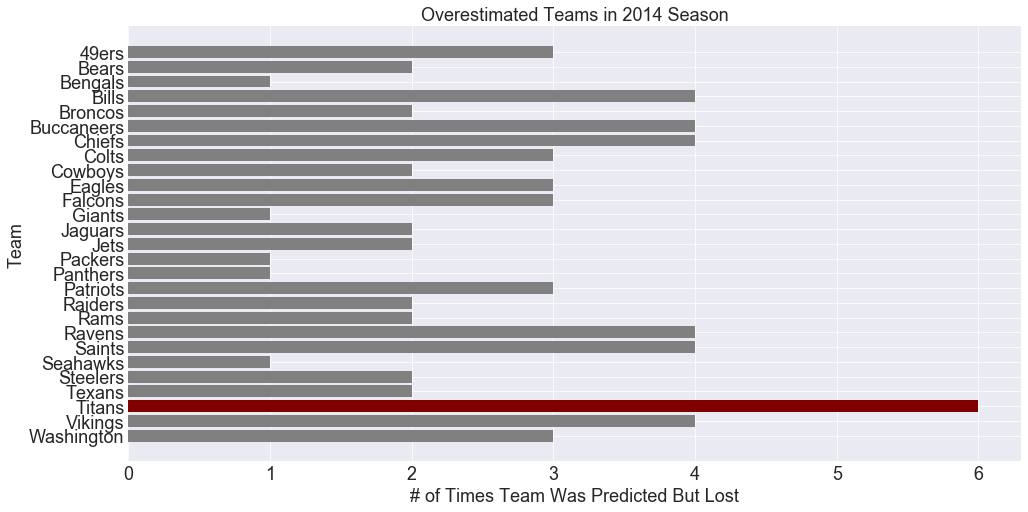

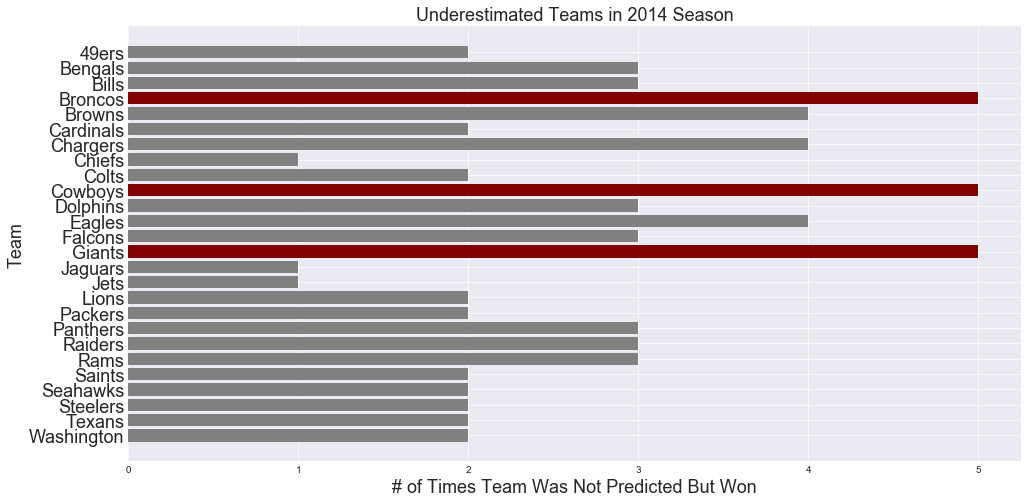

In [385]:
year = 2014

oest_df, uest_df = overunderest(year=year)

team = oest_df['Team'] 
count = oest_df['Count']
color = []

for number in count:
    if number == count.max():
        color.append('maroon')
    else:
        color.append('gray')
    
plt.figure(figsize=(16,8))
plt.barh(team, count, color=color)

# we also need to switch the labels
plt.xlabel('# of Times Team Was Predicted But Lost', fontsize=18)
plt.ylabel('Team', fontsize=18)
plt.title(f'Overestimated Teams in {year} Season', fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(np.arange(0, count.max()+1, 1), fontsize=18)

# Save
plt.savefig(f'Resources/accuracy_data/figures/overest{year}_barhchart.png')

team = uest_df['Team'] 
count = uest_df['Count']
color = []

for number in count:
    if number == count.max():
        color.append('maroon')
    else:
        color.append('gray')

plt.figure(figsize=(16,8))
plt.barh(team, count, color=color)

# we also need to switch the labels
plt.xlabel('# of Times Team Was Not Predicted But Won', fontsize=18)
plt.ylabel('Team', fontsize=18)
plt.title(f'Underestimated Teams in {year} Season', fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(np.arange(0, count.max()+1, 1), fontsize=18)

# Save
plt.savefig(f'Resources/accuracy_data/figures/underest{year}_barhchart.png')

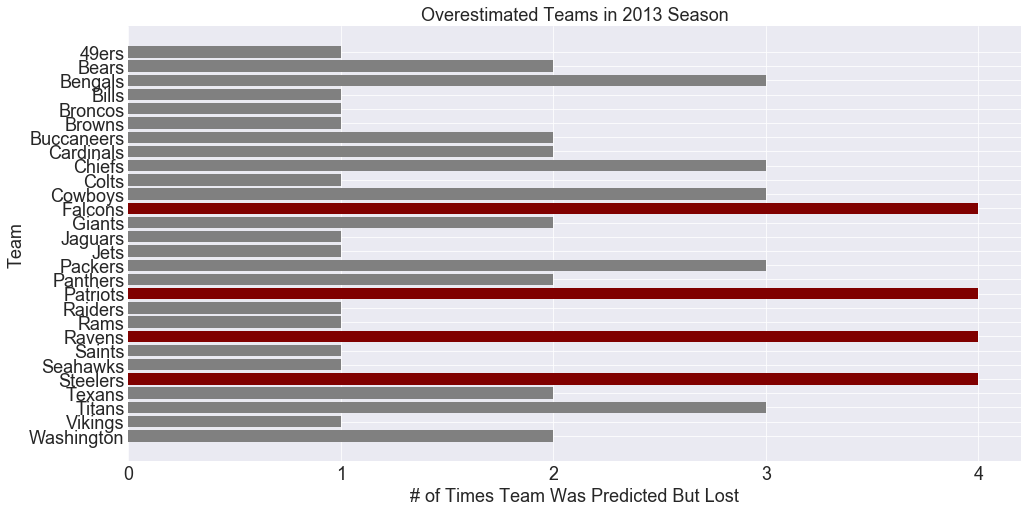

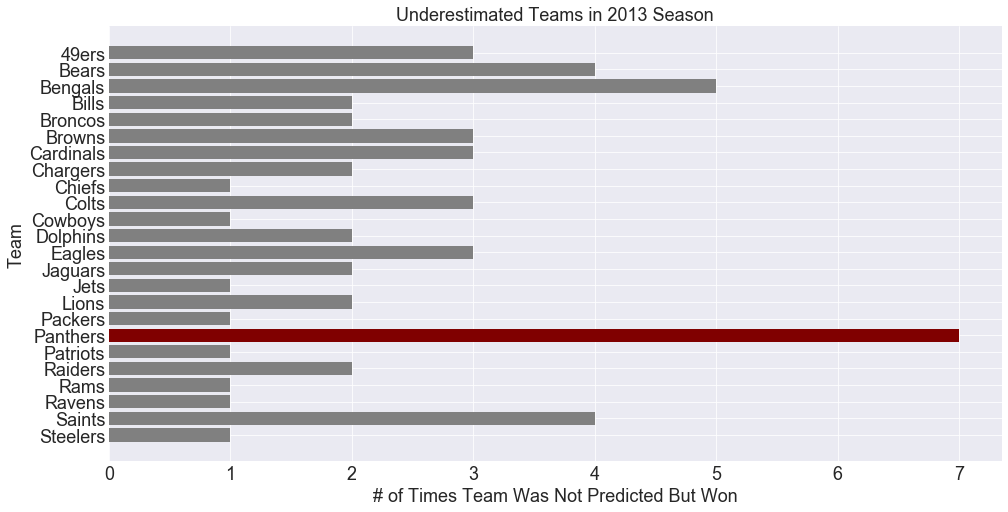

In [387]:
year = 2013

oest_df, uest_df = overunderest(year=year)

team = oest_df['Team'] 
count = oest_df['Count']
color = []

for number in count:
    if number == count.max():
        color.append('maroon')
    else:
        color.append('gray')
    
plt.figure(figsize=(16,8))
plt.barh(team, count, color=color)

# we also need to switch the labels
plt.xlabel('# of Times Team Was Predicted But Lost', fontsize=18)
plt.ylabel('Team', fontsize=18)
plt.title(f'Overestimated Teams in {year} Season', fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(np.arange(0, count.max()+1, 1), fontsize=18)

# Save
plt.savefig(f'Resources/accuracy_data/figures/overest{year}_barhchart.png')

team = uest_df['Team'] 
count = uest_df['Count']
color = []

for number in count:
    if number == count.max():
        color.append('maroon')
    else:
        color.append('gray')

plt.figure(figsize=(16,8))
plt.barh(team, count, color=color)

# we also need to switch the labels
plt.xlabel('# of Times Team Was Not Predicted But Won', fontsize=18)
plt.ylabel('Team', fontsize=18)
plt.title(f'Underestimated Teams in {year} Season', fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(np.arange(0, count.max()+1, 1), fontsize=18)

# Save
plt.savefig(f'Resources/accuracy_data/figures/underest{year}_barhchart.png')

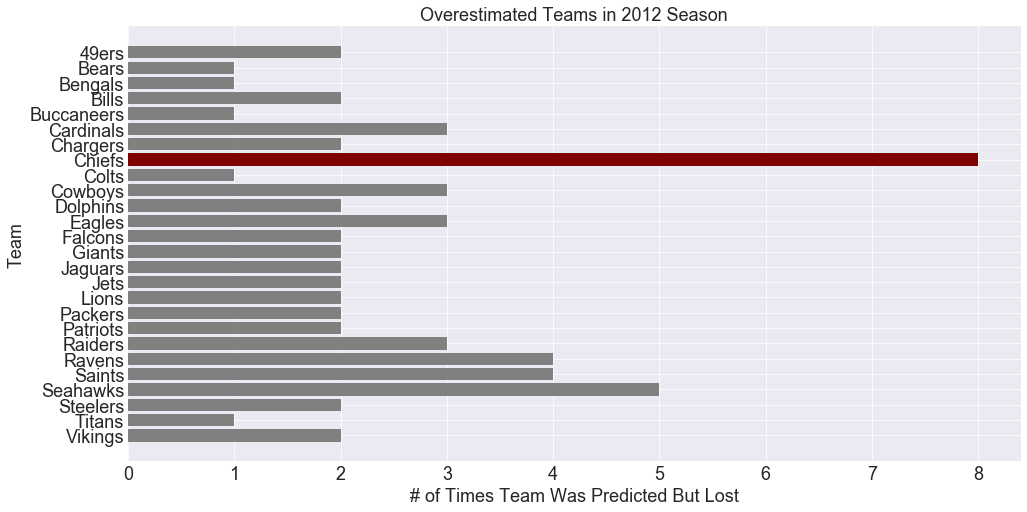

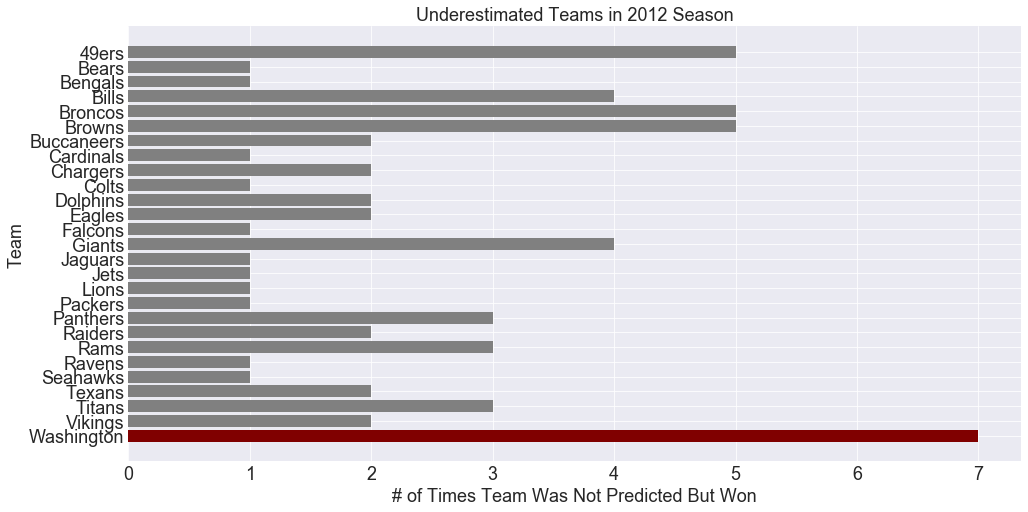

In [388]:
year = 2012

oest_df, uest_df = overunderest(year=year)

team = oest_df['Team'] 
count = oest_df['Count']
color = []

for number in count:
    if number == count.max():
        color.append('maroon')
    else:
        color.append('gray')
    
plt.figure(figsize=(16,8))
plt.barh(team, count, color=color)

# we also need to switch the labels
plt.xlabel('# of Times Team Was Predicted But Lost', fontsize=18)
plt.ylabel('Team', fontsize=18)
plt.title(f'Overestimated Teams in {year} Season', fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(np.arange(0, count.max()+1, 1), fontsize=18)

# Save
plt.savefig(f'Resources/accuracy_data/figures/overest{year}_barhchart.png')

team = uest_df['Team'] 
count = uest_df['Count']
color = []

for number in count:
    if number == count.max():
        color.append('maroon')
    else:
        color.append('gray')

plt.figure(figsize=(16,8))
plt.barh(team, count, color=color)

# we also need to switch the labels
plt.xlabel('# of Times Team Was Not Predicted But Won', fontsize=18)
plt.ylabel('Team', fontsize=18)
plt.title(f'Underestimated Teams in {year} Season', fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(np.arange(0, count.max()+1, 1), fontsize=18)

# Save
plt.savefig(f'Resources/accuracy_data/figures/underest{year}_barhchart.png')

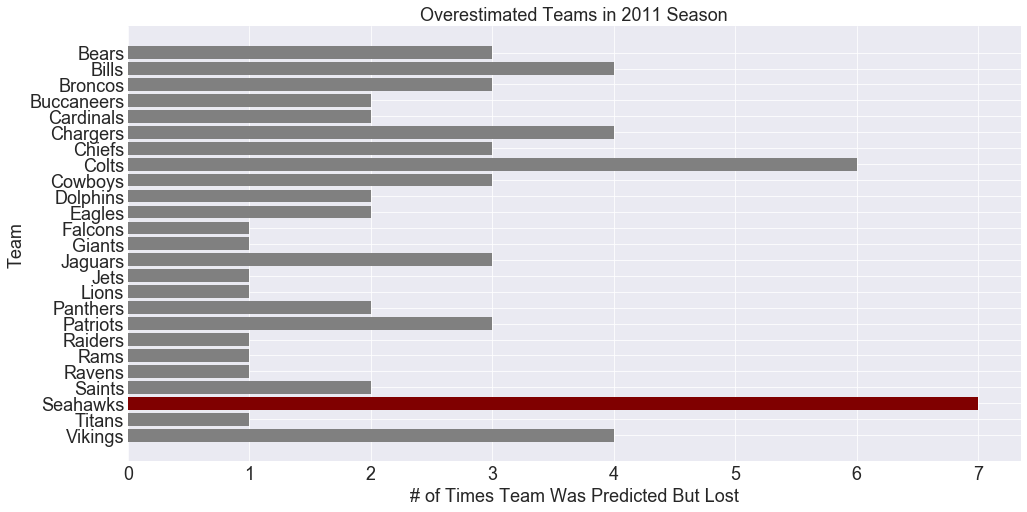

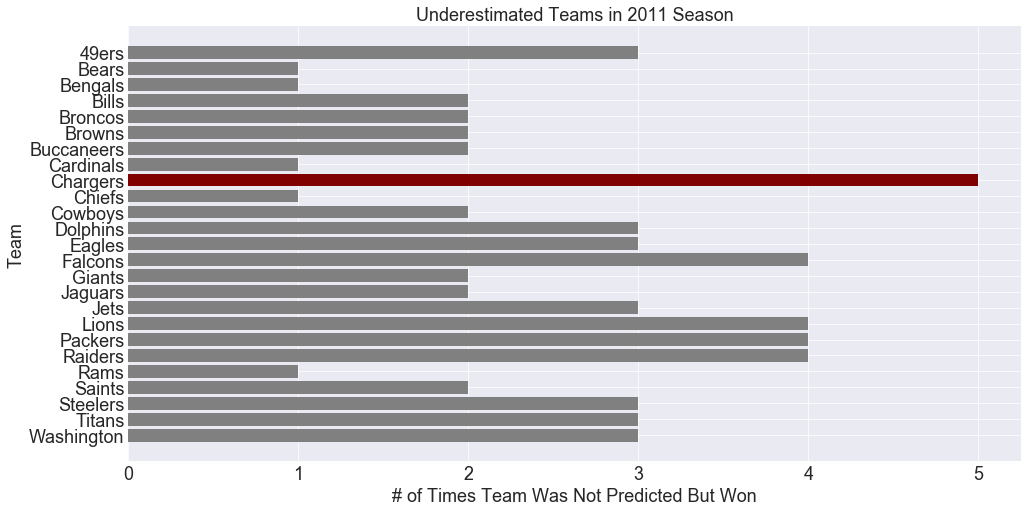

In [389]:
year = 2011

oest_df, uest_df = overunderest(year=year)

team = oest_df['Team'] 
count = oest_df['Count']
color = []

for number in count:
    if number == count.max():
        color.append('maroon')
    else:
        color.append('gray')
    
plt.figure(figsize=(16,8))
plt.barh(team, count, color=color)

# we also need to switch the labels
plt.xlabel('# of Times Team Was Predicted But Lost', fontsize=18)
plt.ylabel('Team', fontsize=18)
plt.title(f'Overestimated Teams in {year} Season', fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(np.arange(0, count.max()+1, 1), fontsize=18)

# Save
plt.savefig(f'Resources/accuracy_data/figures/overest{year}_barhchart.png')

team = uest_df['Team'] 
count = uest_df['Count']
color = []

for number in count:
    if number == count.max():
        color.append('maroon')
    else:
        color.append('gray')

plt.figure(figsize=(16,8))
plt.barh(team, count, color=color)

# we also need to switch the labels
plt.xlabel('# of Times Team Was Not Predicted But Won', fontsize=18)
plt.ylabel('Team', fontsize=18)
plt.title(f'Underestimated Teams in {year} Season', fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(np.arange(0, count.max()+1, 1), fontsize=18)

# Save
plt.savefig(f'Resources/accuracy_data/figures/underest{year}_barhchart.png')

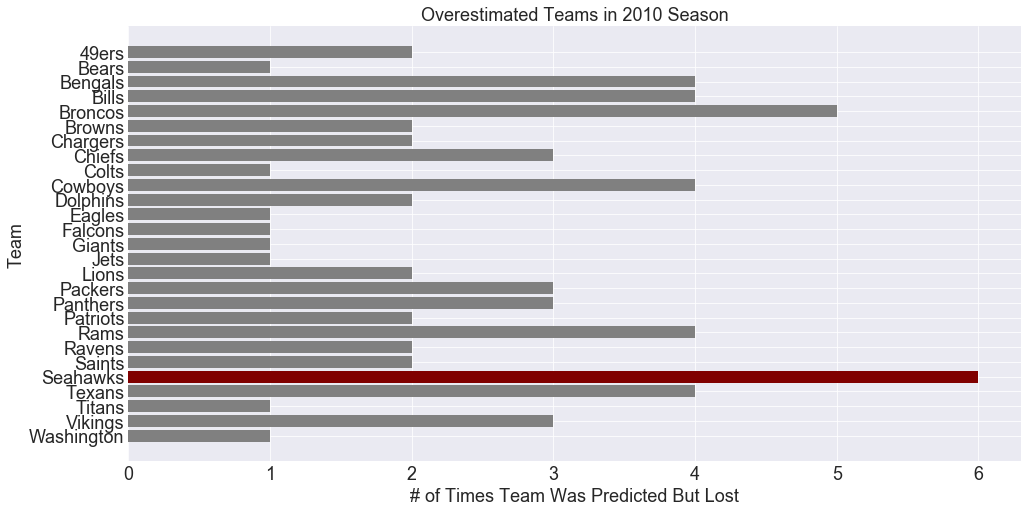

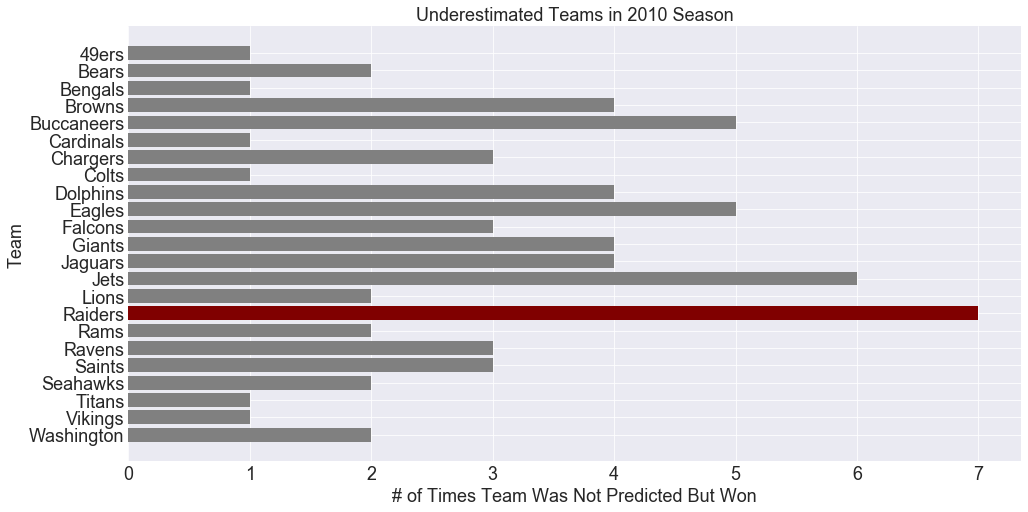

In [390]:
year = 2010

oest_df, uest_df = overunderest(year=year)

team = oest_df['Team'] 
count = oest_df['Count']
color = []

for number in count:
    if number == count.max():
        color.append('maroon')
    else:
        color.append('gray')
    
plt.figure(figsize=(16,8))
plt.barh(team, count, color=color)

# we also need to switch the labels
plt.xlabel('# of Times Team Was Predicted But Lost', fontsize=18)
plt.ylabel('Team', fontsize=18)
plt.title(f'Overestimated Teams in {year} Season', fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(np.arange(0, count.max()+1, 1), fontsize=18)

# Save
plt.savefig(f'Resources/accuracy_data/figures/overest{year}_barhchart.png')

team = uest_df['Team'] 
count = uest_df['Count']
color = []

for number in count:
    if number == count.max():
        color.append('maroon')
    else:
        color.append('gray')

plt.figure(figsize=(16,8))
plt.barh(team, count, color=color)

# we also need to switch the labels
plt.xlabel('# of Times Team Was Not Predicted But Won', fontsize=18)
plt.ylabel('Team', fontsize=18)
plt.title(f'Underestimated Teams in {year} Season', fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(np.arange(0, count.max()+1, 1), fontsize=18)

# Save
plt.savefig(f'Resources/accuracy_data/figures/underest{year}_barhchart.png')

# Week 6

In [548]:
def accuracy_df_2020(year=2020, adv='none'):
    
    column_names = ["Year", "Week", "Weekly_Rate_Accuracy", "Prior_Rate_Accuracy", "E_Adv_Rate_Accuracy", 
                    "3Agree_Accuracy", "3Agree_Count", "2Agree_Accuracy", "2Agree_Count"]

    plot_df = pd.DataFrame(columns = column_names)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy(week1, year=year, adv=adv)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy(week2, year=year, adv=adv)
    row = [year, 2, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy(week3, year=year, adv=adv)
    row = [year, 3, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy(week4, year=year, adv=adv)
    row = [year, 4, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy(week5, year=year, adv=adv)
    row = [year, 5, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    return plot_df

In [549]:
acc2020_df = accuracy_df_2020()
acc2020_df

,Year,Week,Weekly_Rate_Accuracy,Prior_Rate_Accuracy,E_Adv_Rate_Accuracy,3Agree_Accuracy,3Agree_Count,2Agree_Accuracy,2Agree_Count
0,2020.0,1.0,56.25,68.75,31.25,50.00,4.0,88.89,9.0
1,2020.0,2.0,56.25,56.25,31.25,33.33,3.0,88.89,9.0
2,2020.0,3.0,80.00,66.67,60.00,100.00,5.0,66.67,9.0
3,2020.0,4.0,73.33,73.33,60.00,100.00,5.0,66.67,9.0
4,2020.0,5.0,71.43,64.29,64.29,100.00,3.0,90.00,10.0


In [555]:
for i in range(1,6):
    test_df = acc2020_df[acc2020_df['Week'] == i]
    count = (test_df['3Agree_Accuracy'].sum() * test_df['3Agree_Count'].sum())/100 + (test_df['2Agree_Accuracy'].sum() * test_df['2Agree_Count'].sum())/100
    if i == 3:
        perc = (count/15) * 100
    elif i == 4:
        perc = (count/15) * 100
    elif i == 5:
        perc = (count/14) * 100
    else:
        perc = (count/16) * 100
    print(f'Week: {i}')
    print(f'Correct #: {count:.0f}')
    print(f'Correct %: {perc:.1f}')

Week: 1
Correct #: 10
Correct %: 62.5
Week: 2
Correct #: 9
Correct %: 56.2
Week: 3
Correct #: 11
Correct %: 73.3
Week: 4
Correct #: 11
Correct %: 73.3
Week: 5
Correct #: 12
Correct %: 85.7


In [558]:
predictions(weekly_df=week1, year=2020, adv='none', trunc=True)

---------------
49ers vs. Cardinals :: Cardinals
---------------
Bengals vs. Chargers :: Bengals
---------------
Bills vs. Jets :: Jets
---------------
Broncos vs. Titans :: Broncos
---------------
Chiefs vs. Texans :: Chiefs
---------------
Falcons vs. Seahawks :: Seahawks
---------------
Giants vs. Steelers :: Steelers
---------------
Jaguars vs. Colts :: Jaguars
---------------
Lions vs. Bears :: Lions
---------------
Panthers vs. Raiders :: Raiders
---------------
Patriots vs. Dolphins :: Patriots
---------------
Rams vs. Cowboys :: Rams
---------------
Ravens vs. Browns :: Ravens
---------------
Saints vs. Buccaneers :: Buccaneers
---------------
Vikings vs. Packers :: Packers
---------------
Washington vs. Eagles :: Eagles


In [559]:
predictions(weekly_df=week6, year=2020, adv='none', trunc=False)

---------------
49ers vs. Rams :: 49ers
--
Based on Week: 57.7% chance the 49ers win.
Based on Past: 57.1% chance the 49ers win.
Based on Advs: 66.8% chance the 49ers win.
---------------
Bills vs. Chiefs :: Bills
--
Based on Week: 52.9% chance the Bills win.
Based on Past: 62.5% chance the Chiefs win.
Based on Advs: 68.8% chance the Bills win.
---------------
Buccaneers vs. Packers :: Packers
--
Based on Week: 74.1% chance the Packers win.
Based on Past: 100.0% chance the Packers win.
Based on Advs: 60.6% chance the Buccaneers win.
---------------
Colts vs. Bengals :: Bengals
--
Based on Week: 62.5% chance the Bengals win.
Based on Past: 71.4% chance the Bengals win.
Based on Advs: 63.3% chance the Colts win.
---------------
Cowboys vs. Cardinals :: Cardinals
--
Based on Week: 52.6% chance the Cowboys win.
Based on Past: 80.0% chance the Cardinals win.
Based on Advs: 53.3% chance the Cardinals win.
---------------
Dolphins vs. Jets :: Dolphins
--
Based on Week: 52.4% chance the Dolphi